In [2]:
import os
import pandas as pd

###
# This script is used to extract measurement data from the raw logs
##
testfile = "data/stationary/enb.log"


def extract_log_data(logfile):
    with open(logfile, "r") as f:
        log_data = f.readlines()
    log_data = [x.strip() for x in log_data]
    log_data = [
        [x[:26], x[28:35].strip(), x[38:39], x[41:]] for x in log_data if x != ""
    ]
    log_data = pd.DataFrame(
        log_data, columns=["timestamp", "thread", "level", "message"]
    )
    return log_data


def get_measurement_data(logfile):
    log_data = extract_log_data(logfile)
    log_data = log_data[
        log_data["message"].str.contains("MEAS:  New measurement", na=False)
    ]
    log_data[["measurement_type", "earfcn", "pci", "rsrp", "cfo"]] = (
        log_data.message.str.extract(
            r"MEAS:  New measurement (serving|neighbour) cell: earfcn=(.*), pci=(.*), rsrp=(.*) dBm, cfo=(.*) Hz"
        )
    )
    log_data = log_data[["timestamp", "measurement_type", "pci", "rsrp"]]
    log_data["timestamp"] = pd.to_datetime(log_data["timestamp"])
    log_data["pci"] = log_data["pci"].astype(int)
    log_data["rsrp"] = log_data["rsrp"].astype(float)
    return log_data


def smoothed_rsrp(log_data, window_ms=50):
    cells = []
    # smooth rsrp values within each pci
    smooth_data = log_data.copy()
    smooth_data.set_index("timestamp", inplace=True)
    for pci in log_data.pci.unique():
        smooth_data.loc[smooth_data.pci == pci, "rsrp"] = (
            smooth_data.loc[smooth_data.pci == pci, "rsrp"]
            .rolling(window=f"{window_ms}ms")
            .mean()
        )

    smooth_data.reset_index(inplace=True)
    return smooth_data


log_data = get_measurement_data(testfile)
print(log_data.head(10))
print(smoothed_rsrp(log_data).head(10))
log_data.info()

                    timestamp measurement_type  pci   rsrp
20 2024-03-05 12:15:23.292707          serving    2 -97.87
24 2024-03-05 12:15:23.311741          serving    2 -97.79
45 2024-03-05 12:15:23.331748          serving    2 -97.72
46 2024-03-05 12:15:23.351771          serving    2 -97.68
47 2024-03-05 12:15:23.372730          serving    2 -97.61
81 2024-03-05 12:15:23.393683          serving    2 -97.49
83 2024-03-05 12:15:23.413670          serving    2 -96.25
85 2024-03-05 12:15:23.433670          serving    2 -81.09
87 2024-03-05 12:15:23.453753          serving    2 -94.63
89 2024-03-05 12:15:23.473743          serving    2 -96.86
                   timestamp measurement_type  pci       rsrp
0 2024-03-05 12:15:23.292707          serving    2 -97.870000
1 2024-03-05 12:15:23.311741          serving    2 -97.830000
2 2024-03-05 12:15:23.331748          serving    2 -97.793333
3 2024-03-05 12:15:23.351771          serving    2 -97.730000
4 2024-03-05 12:15:23.372730          ser

In [ ]:
# !for d in data/*; do echo $d; tshark -r "$d/iperf.pcap" -T fields -E separator=, -E header=y -E quote=d -E occurrence=f -e frame.number -e frame.time_epoch -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -e udp.srcport -e udp.dstport -e icmp.type -e icmp.code -e frame.len > "$d/iperf.csv"; done

data/failed
data/stationary
data/walking1
tshark: The file "data/walking1/iperf.pcap" doesn't exist.
data/walking2
data/walking3
data/walking4


Handover: 2 -> 1 at 2024-03-05 12:16:27.111613
Handover: 1 -> 2 at 2024-03-05 12:17:02.211275
Handover: 2 -> 4 at 2024-03-05 12:19:36.106874


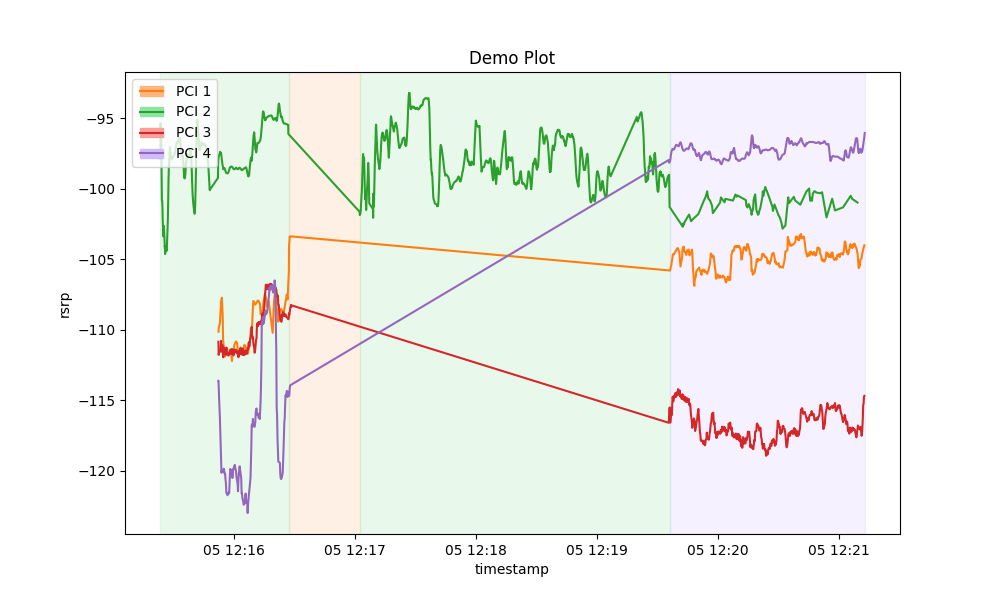

In [11]:
###
# Plotting the logs
##

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import pyshark

log_data = get_measurement_data(testfile)
smoothed_data = smoothed_rsrp(log_data, window_ms=1000)


# # Create a custom legend handler to combine rectangle and line
class PCILegendHandler(HandlerTuple):
    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        rect: mpl.patches.Rectangle = orig_handle[0]
        line: mpl.lines.Line2D = orig_handle[1]
        # Adjust the position and size of the line
        line.set_transform(trans)

        # Add the white line before line
        line_white = mpl.lines.Line2D((0.5, 1), (0.5, 0.5), color="white")
        line.set_xdata([0.1 * width, 0.9 * width])
        line.set_ydata([0.5 * height, 0.5 * height])
        rect.set_transform(trans)
        # Adjust the position and size of the rectangle
        # rect.set_transform(trans)
        rect.set_xy([0.08 * width, 0])
        rect.set_width(0.83 * width)
        rect.set_height(1 * height)

        artists = (rect, line, line_white)
        return artists


def plot_rsrp_vs_time(
    log_data, print_handover=False, title="RSRP vs Time", ax=None, show=True
):
    n_pci = log_data["pci"].nunique()
    line_cmap = sns.color_palette()[
        min(log_data["pci"].unique()) : n_pci + min(log_data["pci"].unique())
    ]
    area_cmap = sns.color_palette("pastel")
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(
        x="timestamp", y="rsrp", data=log_data, hue="pci", palette=line_cmap, ax=ax
    )
    plt.title(title)
    # Show current serving cell
    serving_cell = log_data[log_data["measurement_type"] == "serving"]
    pcis_labelled = []
    # Shade in background to indicate serving cell's pci
    current_pci = serving_cell["pci"].values[0]
    current_timestamp = serving_cell["timestamp"].values[0]
    for i, row in serving_cell.iterrows():
        if row["pci"] != current_pci:
            if print_handover:
                print(
                    "Handover:", f"{current_pci} -> {row['pci']} at {row['timestamp']}"
                )

            if current_pci not in pcis_labelled:
                pcis_labelled.append(current_pci)
                ax.axvspan(
                    current_timestamp,
                    row["timestamp"],
                    color=area_cmap[current_pci],
                    alpha=0.2,
                )
            else:
                ax.axvspan(
                    current_timestamp,
                    row["timestamp"],
                    color=area_cmap[current_pci],
                    alpha=0.2,
                )
            current_pci = row["pci"]
            current_timestamp = row["timestamp"]
    if current_pci not in pcis_labelled:
        pcis_labelled.append(current_pci)
        ax.axvspan(
            current_timestamp,
            row["timestamp"],
            color=area_cmap[current_pci],
            alpha=0.2,
        )
    else:
        ax.axvspan(
            current_timestamp, row["timestamp"], color=area_cmap[current_pci], alpha=0.2
        )
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []

    # Iterate through each handle and label
    for handle, label in zip(handles, labels):
        # Extract the color of the line
        color = handle.get_color()

        # Create a new rectangle with the same color as the line
        rect = plt.Rectangle(
            (0, 0), 1, 1, fc=area_cmap[int(label)], ec=area_cmap[int(label)]
        )
        line = plt.Line2D((0, 1), (0.5, 0.5), color=color)
        combined_handle = (rect, line)
        new_handles.append(combined_handle)
        new_labels.append(f"PCI {label}")

    ax.legend(
        handles=new_handles,
        labels=new_labels,
        loc="upper left",
        handler_map={tuple: PCILegendHandler()},
    )
    if show:
        plt.show()


plot_rsrp_vs_time(smoothed_data, print_handover=True, title="Demo Plot")

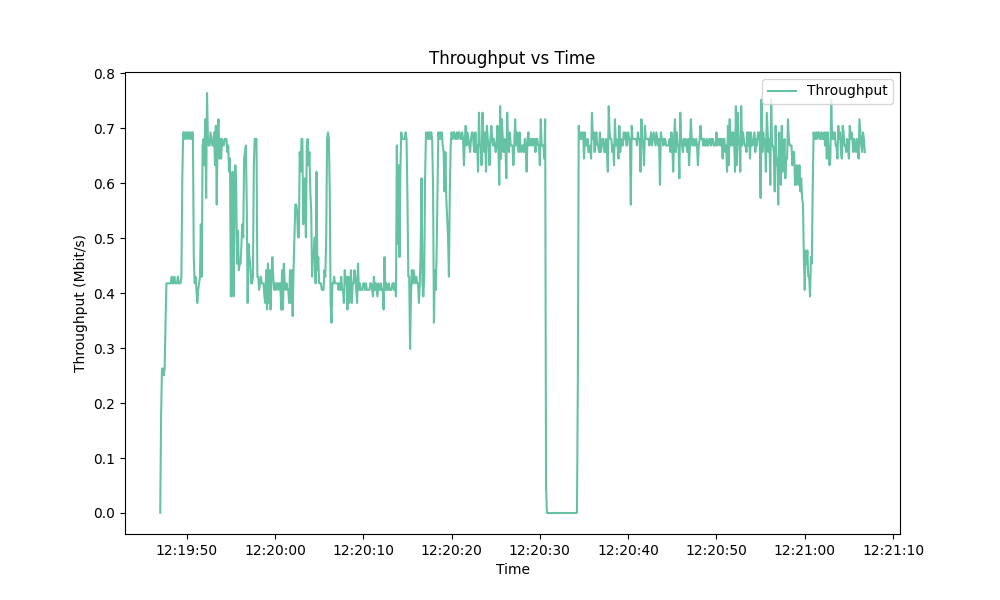

In [14]:
def plot_throughput_vs_time(pcap_file, title="Throughput vs Time", ax=None, show=True):
    # pcap_file = "data/stationary/iperf.csv"
    throughput = pd.read_csv(pcap_file)  # Convert packets to a DataFrame

    # Rest of your code...
    throughput["timestamp"] = pd.to_datetime(throughput["frame.time_epoch"], unit="s")
    throughput.set_index("timestamp", inplace=True)

    throughput["length"] = throughput["frame.len"]
    throughput["udp.dstport"] = throughput["udp.dstport"].astype(int, errors="ignore")
    throughput = throughput[throughput["udp.dstport"] == 5201]
    throughput = throughput[["length"]]
    # Set length from bytes to Mbits

    throughput = throughput.resample("100ms").sum()  # Resample to 100ms intervals

    throughput["length"] = throughput["length"] * 8 / 1e6

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel("Time")
    ax.set_ylabel("Throughput (Mbit/s)")
    ax.plot(throughput.index, throughput["length"], c=sns.color_palette("Set2")[0])
    ax.set_title(title)

    ax.legend(["Throughput"], loc="upper right")

    if show:
        plt.show()


plot_throughput_vs_time("data/stationary/iperf.csv")

In [5]:
throughput = pd.read_csv("data/stationary/iperf.csv")  # Convert packets to a DataFrame

# Rest of your code...
throughput["timestamp"] = pd.to_datetime(throughput["frame.time_epoch"], unit="s")
throughput.set_index("timestamp", inplace=True)

throughput["length"] = throughput["frame.len"]
throughput["udp.dstport"] = throughput["udp.dstport"].astype(int, errors="ignore")
throughput = throughput[throughput["udp.dstport"] == 5201]
throughput = throughput[["length", "frame.number"]]
# Set length from bytes to Mbits
throughput["length"] = throughput["length"] * 8 / 1e6
# throughput = throughput.resample("1s").sum()

packets = throughput.between_time("12:20:29", "12:20:35")
# plot when the packets are coming in
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_xlabel("Time")
# ax.set_ylabel("Packet Count")
# ax.plot(packets.index, packets["length"], c=sns.color_palette("Set2")[0])
packets.head(1330)

,length,frame.number
timestamp,,
2024-03-05 12:20:29.000622034,0.011936,18865
2024-03-05 12:20:29.001511097,0.011936,18866
2024-03-05 12:20:29.003582954,0.011936,18867
2024-03-05 12:20:29.005628109,0.011936,18868
2024-03-05 12:20:29.007679939,0.011936,18869
...,...,...
2024-03-05 12:20:34.992608070,0.011936,20212
2024-03-05 12:20:34.993489981,0.011936,20213
2024-03-05 12:20:34.995707989,0.011936,20214


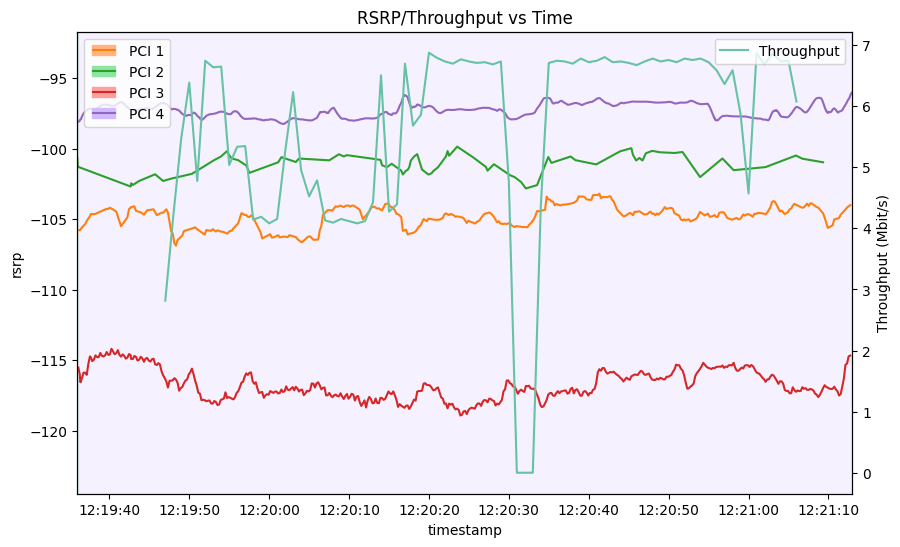

In [6]:
def plot_experiment(
    logfile, pcapfile, title="RSRP/Throughput vs Time", from_time=None, to_time=None
):
    log_data = get_measurement_data(logfile)
    smoothed_data = smoothed_rsrp(log_data, window_ms=1000)
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_rsrp_vs_time(
        smoothed_data, print_handover=False, title=title, ax=ax, show=False
    )
    ax2 = ax.twinx()
    plot_throughput_vs_time(pcapfile, title="", ax=ax2, show=False)
    # Limit the time range
    if from_time is not None and to_time is not None:
        # convert from HH:MM:SS to datetime, get the first date from the log data
        start_time = log_data["timestamp"].dt.date.iloc[0]
        from_time = pd.to_datetime(f"{start_time} {from_time}")
        to_time = pd.to_datetime(f"{start_time} {to_time}")
        ax.set_xlim(from_time, to_time)
        ax2.set_xlim(from_time, to_time)
    plt.show()


plot_experiment(
    "data/stationary/enb.log",
    "data/stationary/iperf.csv",
    from_time="12:19:36",
    to_time="12:21:13",
)

walking1


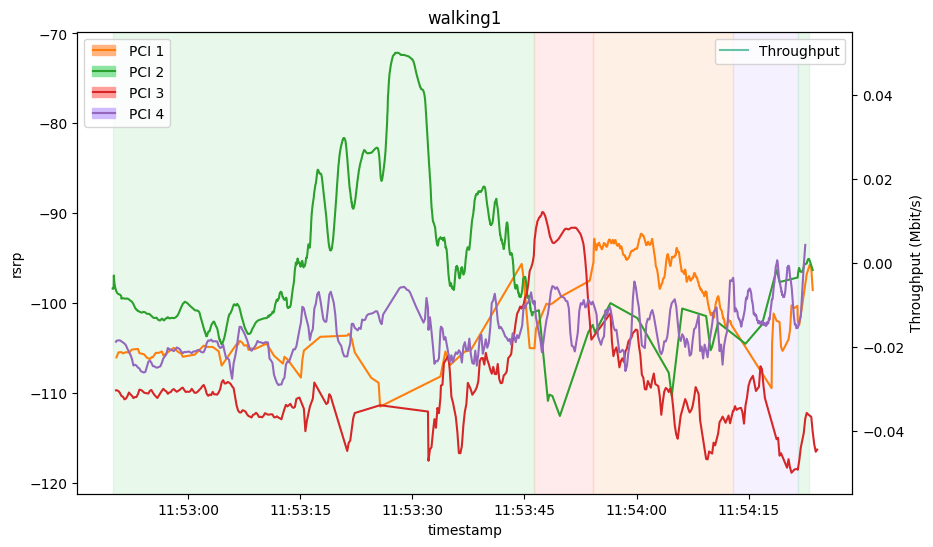

walking4


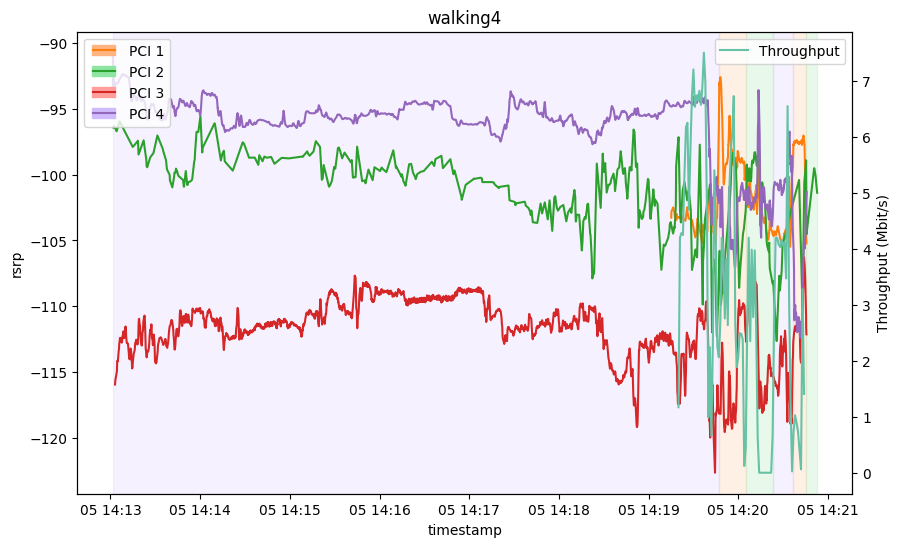

walking3


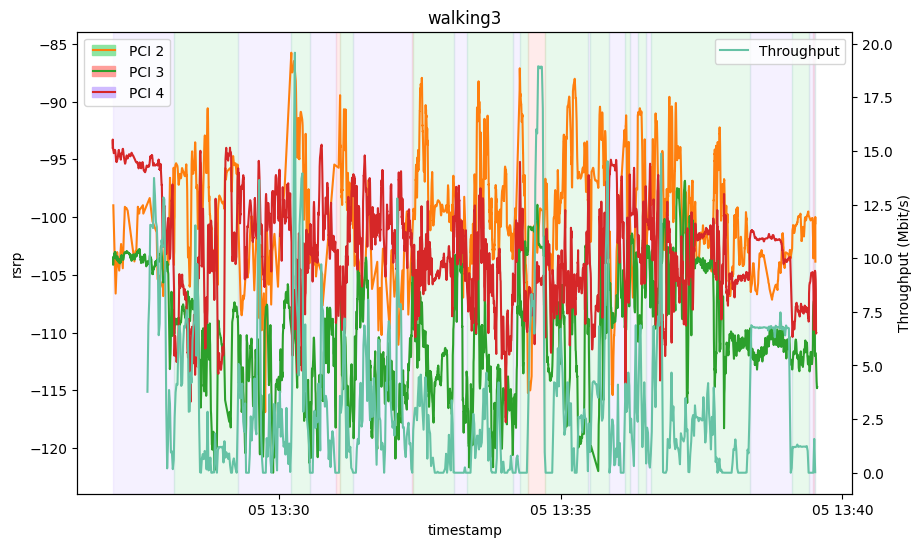

stationary


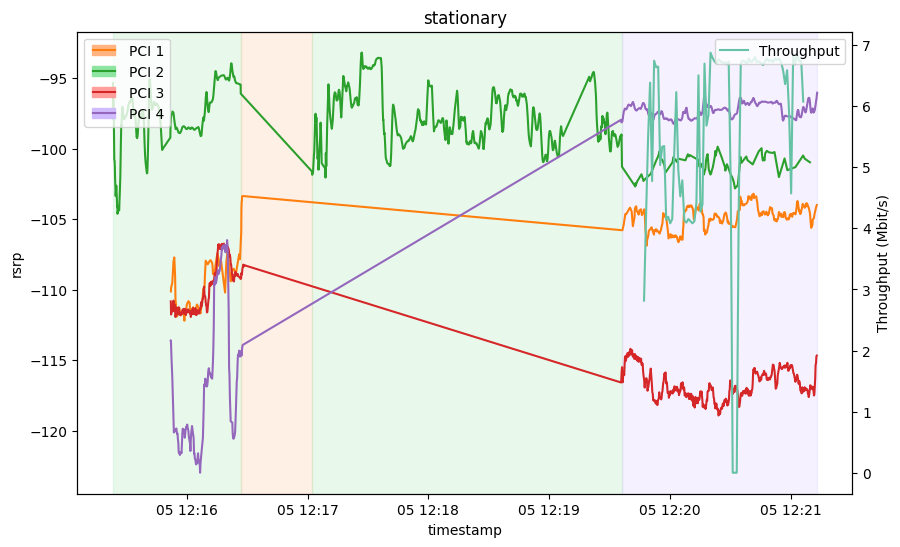

failed


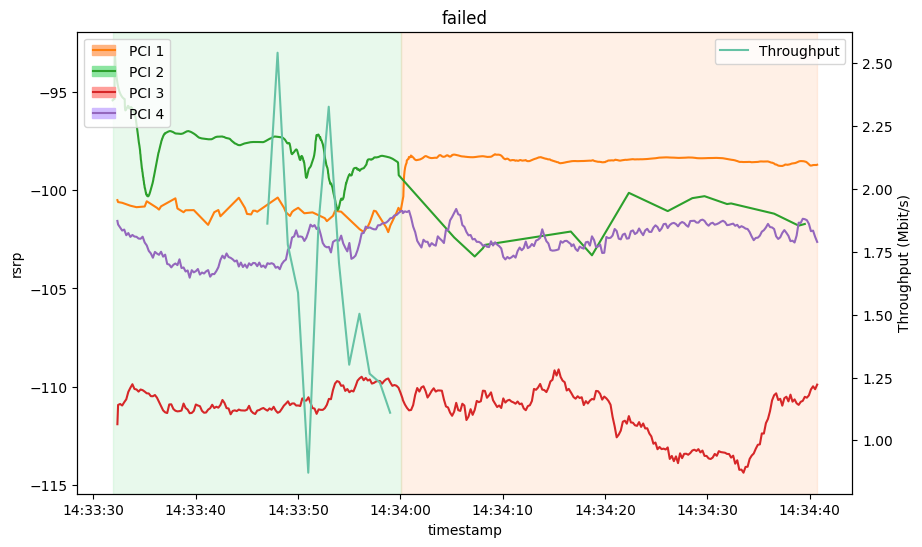

walking2


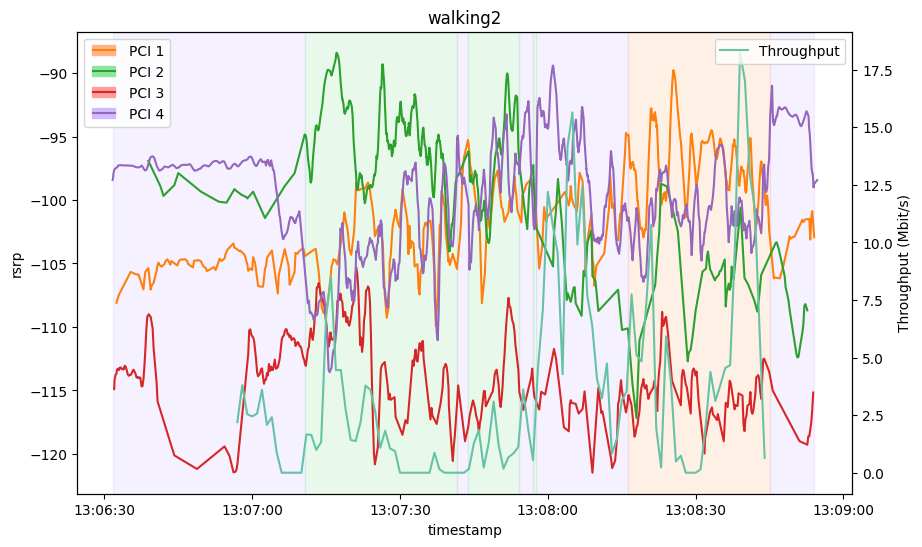

In [7]:
for d in os.listdir("data"):
    if os.path.isdir(f"data/{d}"):
        print(d)
        log_file = f"data/{d}/enb.log"
        pcap_file = f"data/{d}/iperf.csv"
        plot_experiment(log_file, pcap_file, title=d)

In [ ]:
# Import plot experiment from utils log_viewer in parent directory, and reload when it changes
# We need to add parent directory to path
import sys
sys.path.append("..")

from importlib import reload
import utils.log_viewer
reload(utils.log_viewer)
from utils.log_viewer import plot_experiment

%matplotlib widget
experiment = "failed"
for rsrp_smoothing in [10, 100, 500, 1000, 2000, 5000]:
    plot_experiment(
        f"data/{experiment}/enb.log",
        f"data/{experiment}/iperf.csv",
        smooth_rsrp_ms=rsrp_smoothing,
        from_time="14:33:45",
        to_time="14:34:00",
        title=f"RSRP Smoothing: {rsrp_smoothing}ms",
    )

In [ ]:
experiment = "stationary"
for throughput_smoothing in [10, 100, 500, 1000, 2000, 5000]:
    plot_experiment(
        f"data/{experiment}/enb.log",
        f"data/{experiment}/iperf.csv",
        smooth_throughput_ms=throughput_smoothing,
        # from_time="14:33:45",
        # to_time="14:34:00",
        title=f"RSRP Smoothing: {throughput_smoothing}ms",
    )